## House roof type detection & counting

**The objective of this competition is to create a machine-learning algorithm that counts the number of grass-thatch, tin and other roofed houses** in aerial (drone) imagery. 

Ensuring more accurate estimates of affected populations in the case of a disaster allows these communities to be evacuated or for aid to be provided more effectively

In [ ]:
#%pip install ultralytics

In [1]:
import pprint
import os
import gc
import shutil
import yaml
from dataclasses import dataclass
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import torch
import ultralytics
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
ultralytics.checks()

#!yolo predict model=yolov8n.pt source='https://ultralytics.com/images/zidane.jpg'

Ultralytics YOLOv8.1.34 🚀 Python-3.11.4 torch-2.1.0 CPU (Apple M2 Pro)
Setup complete ✅ (12 CPUs, 16.0 GB RAM, 445.8/926.4 GB disk)


## Data Preprocessing

In [3]:
# data exploration and prep
@dataclass
class Config:
  seed = 7777
  base_data_dir = "./datasets/data"
  image_dir = os.path.join(base_data_dir, "images")
  train_csv = os.path.join(base_data_dir, "Train.csv")
  test_csv = os.path.join(base_data_dir, "Test.csv")

In [4]:
train_df = pd.read_csv(Config.train_csv)
test_df = pd.read_csv(Config.test_csv)
print(f"Total Num. Image files: {len(os.listdir(Config.image_dir))}")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Total Num. Image files: 6817
Train shape: (26156, 4)
Test shape: (2045, 1)


In [5]:
train_df["image_path"] = train_df["image_id"].apply(lambda x: os.path.join(Config.image_dir, "".join([x, ".tif"])))
train_df.head()

image_id                        bbox  category_id      id  \
0  id_w55q2qr62fsk    [122.0, 1.0, 42.0, 30.0]          2.0  6356.0   
1  id_fvldv7o1kn9d  [500.0, 141.0, 74.0, 70.0]          2.0  2305.0   
2  id_5d1r9l1jp7b5  [304.0, 525.0, 54.0, 58.0]          2.0   238.0   
3  id_45qru79t6s4n  [187.0, 298.0, 44.0, 56.0]          2.0   921.0   
4  id_84cjf2pbqmtv  [349.0, 721.0, 58.0, 59.0]          2.0  1362.0   

                                   image_path  
0  ./datasets/data/images/id_w55q2qr62fsk.tif  
1  ./datasets/data/images/id_fvldv7o1kn9d.tif  
2  ./datasets/data/images/id_5d1r9l1jp7b5.tif  
3  ./datasets/data/images/id_45qru79t6s4n.tif  
4  ./datasets/data/images/id_84cjf2pbqmtv.tif

In [6]:
## sanitize bbox dtypes
res = []
for r in train_df["bbox"]:
  try:
    res.append([float(i.strip(' []')) for i in r.split(",")])
  except:
    res.append([float(i) for i in str(r).strip(' []').split(",")])

train_df["bboxes"] = res
del res
gc.collect()

24

In [7]:
train_df.dtypes

image_id        object
bbox            object
category_id    float64
id             float64
image_path      object
bboxes          object
dtype: object

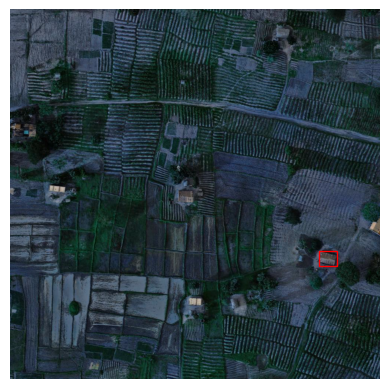

In [8]:
## from xyxy to xywh(yolo) format
def xxyxy_xywh(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
##

sample = train_df["image_path"][39]
bbox = train_df["bboxes"][39] #xywh bbox format
img = cv2.imread(sample) #Image.open('a_image.tif')
## from yolo to xyxy format
#x1, y1 = bbox[0] - bbox[2] / 2, bbox[1] - bbox[3] / 2
#x2, y2 = bbox[0] + bbox[2] / 2, bbox[1] + bbox[3] / 2

fig, ax = plt.subplots()

ax.imshow(img)
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.axis('off')  # Turn off axis
plt.show()


category_id
2.0    21330
3.0     2348
1.0      171
Name: count, dtype: int64


<Axes: xlabel='category_id'>

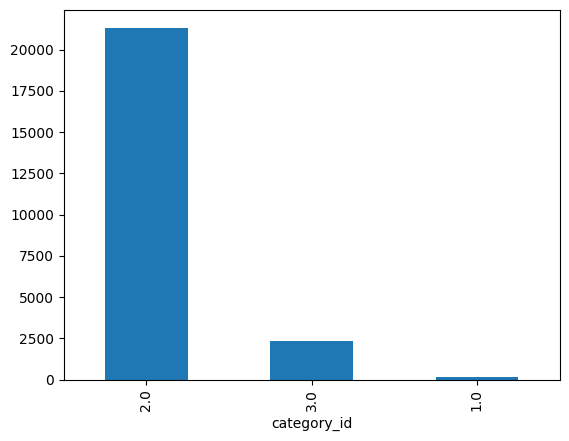

In [9]:
pprint.pprint(train_df["category_id"].value_counts())
train_df["category_id"].value_counts().plot(kind='bar')

Image shapes: (1000, 1000, 3)
Image shapes: (1000, 1000, 3)
Image shapes: (500, 500, 3)
Image shapes: (1000, 1000, 3)
Image shapes: (500, 500, 3)
Image shapes: (500, 500, 3)
Image shapes: (500, 500, 3)
Image shapes: (1000, 1000, 3)
Image shapes: (1000, 1000, 3)


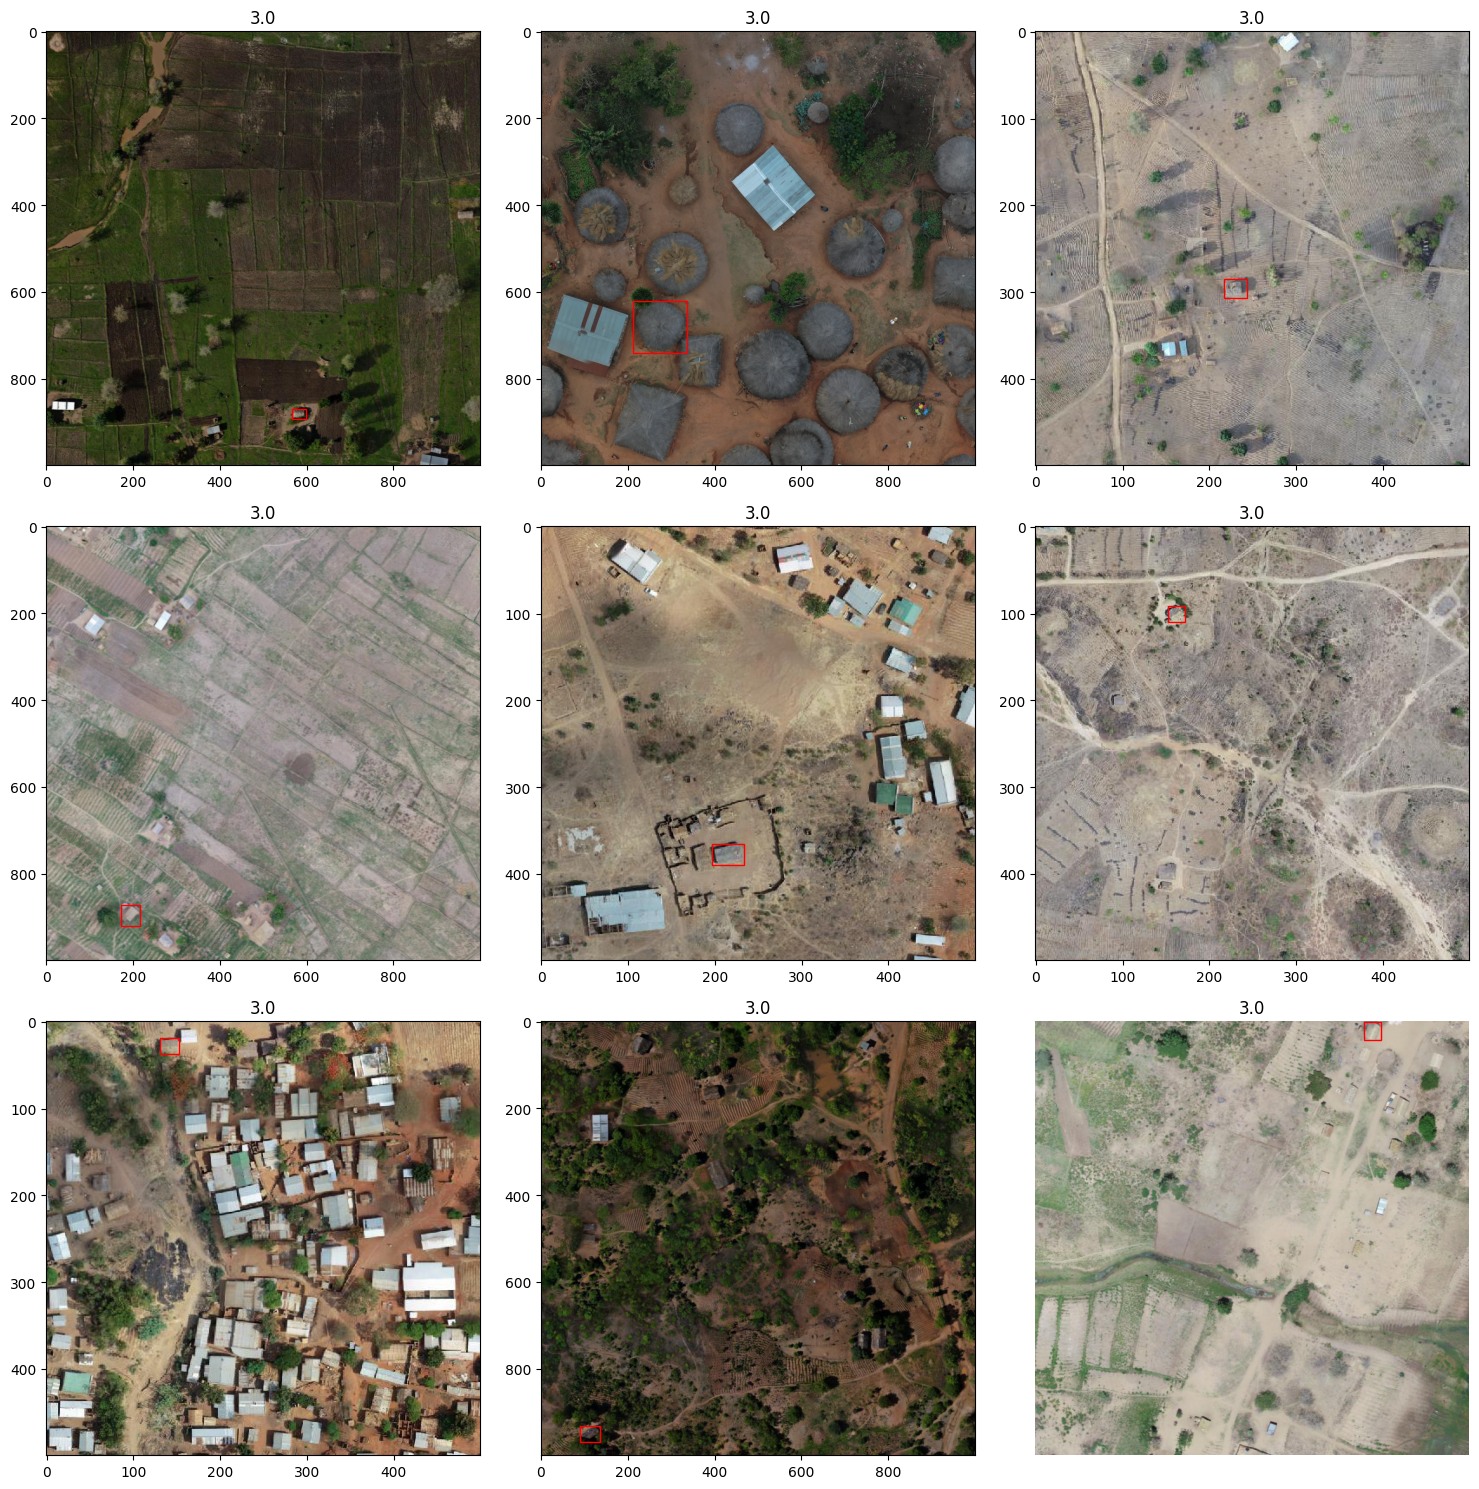

In [10]:
def plot_images(
    df: pd.DataFrame,
    n_samples: int,
    cat: int,
    seed: int,
    verbose: bool=False
):
    """Visualize a sample of images & their bbox annotations for a given roof category."""
    plot_list = df[df["category_id"] == cat].sample(n_samples, random_state=seed)[["image_path", "bboxes"]]
    if verbose:
        print(f"Sampled Image IDs:\n{plot_list}")

    labels = [cat for i in range(len(plot_list))]
    size = np.sqrt(n_samples)
    if int(size) * int(size) < n_samples:
        size = int(size) + 1

    # Create the figure and a 3x3 grid of subplots
    fig, axes = plt.subplots(int(size), int(size), figsize=(15, 15))

    for idx, (image_path, bbox, label) in enumerate(zip(plot_list["image_path"], plot_list["bboxes"], labels)):
        image = cv2.imread(image_path)
        print(f"Image shapes: {image.shape}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Retrieve the correct subplot using the index
        ax = axes.flat[idx]

        ax.imshow(image)
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.axis('off')  # Turn off axis
        ax.set_title(label, fontsize=12)

    plt.tight_layout()
    plt.show()

plot_images(df=train_df, n_samples=9, cat=3.0, seed=np.random.randint(100), verbose=False)

In [11]:
train_df = train_df[["image_id", "bboxes", "category_id", "id"]]

In [12]:
IMAGE_WIDTH = 512 #640
IMAGE_HEIGHT = 512 #640

"""
def clip_bbox(bbox, image_width, image_height):
  ""Clips bounding box coordinates (xywh format) to stay within image bounds.

  Args:
    bbox: [x_center, y_center, width, height].
    image_width: Image width.
    image_height: Image height.

  Returns:
    Clipped bounding box coordinates (xywh format).
  ""
  x_center, y_center, width, height = bbox
  x_min = max(0, x_center - width / 2)  # Clip x-center to stay within image
  y_min = max(0, y_center - height / 2)  # Clip y-center to stay within image
  x_max = min(image_width, x_center + width / 2)  # Clip x-center to stay within image
  y_max = min(image_height, y_center + height / 2)  # Clip y-center to stay within image
  width_clipped = x_max - x_min
  height_clipped = y_max - y_min
  return [x_min, y_min, width_clipped, height_clipped]
"""

#parse the dataset to the YOLO format
def bbox_to_string(bbox):
  """Parse bbox list values into strings."""
  w = bbox[2]
  h = bbox[3]
  xc = min(IMAGE_WIDTH, bbox[0] + w / 2) # enforce coord bounds to prevent OO-bound errors # bbox[0] + int(np.round(w / 2.0))
  yc = min(IMAGE_HEIGHT, bbox[1] + h / 2) # encforce coord bounds # bbox[1] + int(np.round(h / 2.0)) 

  bbox = [xc / IMAGE_WIDTH, yc / IMAGE_HEIGHT, w / IMAGE_WIDTH, h / IMAGE_HEIGHT]
  bbox = [f"{i:.4g}" for i in bbox]
  return " ".join(bbox)


def create_label_folder(label_dir, df):
  """Parse labels into yolo format."""
  if not os.path.exists(label_dir):
    os.makedirs(label_dir)
  
  unique_images = df["image_id"].unique()
  
  for i, img in zip(tqdm(range(len(unique_images))), unique_images):
    dataframe = df[df["image_id"] == img]
    output_lines = []
    for index, row in dataframe.iterrows():
      category_id = int(row["category_id"]) - 1
      bbox_string = bbox_to_string(row["bboxes"])
      output_lines.append(f"{category_id} {bbox_string}")

    with open(f"{label_dir}/{str(img)}.txt", "w") as f:
      for line in output_lines:
        f.write(line + "\n")


def create_image_folders(source: os.PathLike, train_dest: os.PathLike, val_dest: os.PathLike, df):
  """Create train and val image folders for YOLO training."""
  
  if not os.path.exists(train_dest):
    os.makedirs(train_dest)
    
  if not os.path.exists(val_dest):
    os.makedirs(val_dest)
  
  ## split into train, val images
  data_df = df.drop_duplicates(subset="image_id", keep="first").reset_index(drop=True)
  data_df["category_id"] = data_df["category_id"].replace(np.nan, -1.1)
  
  X_train, X_val, y_train, y_val = train_test_split(
    data_df["image_id"],
    data_df["category_id"],
    test_size=0.2,
    stratify=data_df["category_id"],
    random_state=Config.seed
  )

  # create train image folder
  for img in X_train:
    img_path = os.path.join(source, img + ".tif")
    shutil.copy2(img_path, os.path.join(train_dest, img + ".tif"))

  # create val image folder
  for img in X_val:
    img_path = os.path.join(source, img + ".tif")
    shutil.copy2(img_path, os.path.join(val_dest, img + ".tif"))
  
  df.dropna(inplace=True)
  train_idx = np.isin(df["image_id"].values, X_train)
  val_idx = np.isin(df["image_id"].values, X_val)
  print(f"Train, Val shape: {train_idx.shape, val_idx.shape}")

  train_data = df.iloc[train_idx]
  val_data = df.iloc[val_idx]
  print(f"train, val data shape: {train_data.shape, val_data.shape}")
  
  create_label_folder("./datasets/data512/train/labels", train_data)
  create_label_folder("./datasets/data512/val/labels", val_data)
  

IMAGES_FOLDER = "./datasets/data/images/"
TRAIN_DATA_DIR = "./datasets/data512/train/images/"
VAL_DATA_DIR = "./datasets/data512/val/images/"

## RUN ONCE
#create_image_folders(IMAGES_FOLDER, TRAIN_DATA_DIR, VAL_DATA_DIR, train_df)

num_classes = 3
names = ["Thatch", "Tin", "Other"]
train_label_dir = "./datasets/data512/train"
val_label_dir = "./datasets/data512/val"

dict_file = {
  "train": train_label_dir,
  "val": val_label_dir,
  "nc": num_classes,
  "names": names
}

## RUN ONCE
#with open("./data.yaml", 'w+') as file:
#  yaml.dump(dict_file, file)

In [13]:
len(os.listdir("./datasets/data512/train/images")), len(os.listdir("./datasets/data512/val/images"))

(3817, 955)

## Model Training

In [14]:
import wandb

In [15]:
@dataclass
class ModelConf:
  wandb_key: str = ""
  eta: float = 3e-2
  epochs: int = 20
  model_name = "yolov8n"
  device = torch.device("mps")
  batch_size = 32
  run_name = f"{model_name}_imgsz:{IMAGE_HEIGHT}_eps:{epochs}_lr:{eta}_bs:{batch_size}"
  verbose = False
  resume = False
  patience = 5

try:
  wandb.login(key=ModelConf.wandb_key)
except Exception as e:
  print(e)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mugisha. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/smugisha/.netrc


In [16]:
# start a new wandb run to track this script
run = wandb.init(
  # set the wandb project where this run will be logged
  project="thatched_roof_house_count",
  # track hyperparameters and run metadata
  config={
    "learning_rate": ModelConf.eta,
    "architecture": ModelConf.model_name,
    "dataset": "thatched_roof_house_count",
    "epochs": ModelConf.epochs,
    "seed": Config.seed,
  }
)


In [ ]:
model = YOLO(ModelConf.model_name+".pt")

model_artifact = wandb.Artifact(
  name="thatched_roof_counter_yolov8n_512", 
  type="model"
)

#model_artifact.add_file("model_checkpt.pt")
#run.log_artifact(model_artifact)
model

In [18]:
torch.mps.empty_cache()
torch.cuda.empty_cache()
gc.collect()
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

In [19]:
model.train(
  data="./data.yaml",
  epochs=ModelConf.epochs,
  imgsz=IMAGE_HEIGHT,
  task="detect",
  batch=ModelConf.batch_size,
  nbs=32, #64
  lr0=ModelConf.eta,
  optimizer="auto",
  name=ModelConf.run_name,
  seed=Config.seed,
  box=7.5,
  val=True,
  device=ModelConf.device,
  verbose=ModelConf.verbose,
  patience=10,
  workers=18,
  iou=0.9
)


New https://pypi.org/project/ultralytics/8.2.35 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./data.yaml, epochs=20, time=None, patience=10, batch=32, imgsz=512, save=True, save_period=-1, cache=False, device=mps, workers=18, project=None, name=yolov8n_imgsz:512_eps:20_lr:0.03_bs:3216, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=7777, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.9, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sh

train: Scanning /Users/smugisha/Downloads/house_identification/datasets/data512/train/labels.cache... 1972 images, 1845 backgrounds, 0 corrupt: 100%|██████████| 3817/3817 [00:00<?, ?it/s]

train: WARNING ⚠️ /Users/smugisha/Downloads/house_identification/datasets/data512/train/images/id_1ow6ctv4gow6.tif: 1 duplicate labels removed
train: WARNING ⚠️ /Users/smugisha/Downloads/house_identification/datasets/data512/train/images/id_2fva7g8jrx9q.tif: 1 duplicate labels removed



val: Scanning /Users/smugisha/Downloads/house_identification/datasets/data512/val/labels.cache... 493 images, 462 backgrounds, 0 corrupt: 100%|██████████| 955/955 [00:00<?, ?it/s]

val: WARNING ⚠️ /Users/smugisha/Downloads/house_identification/datasets/data512/val/images/id_k90ekyoh61m3.tif: 1 duplicate labels removed
val: WARNING ⚠️ /Users/smugisha/Downloads/house_identification/datasets/data512/val/images/id_pxqmw93nu80s.tif: 1 duplicate labels removed
Plotting labels to runs/detect/yolov8n_imgsz:512_eps:20_lr:0.03_bs:3216/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.03' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/yolov8n_imgsz:512_eps:20_lr:0.03_bs:3216
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      3.254      3.895      1.901         44        512: 100%|██████████| 120/120 [12:26<00:00,  6.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/15 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   7%|▋         | 1/15 [00:45<10:37, 45.55s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  13%|█▎        | 2/15 [01:15<07:56, 36.65s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 3/15 [01:41<06:19, 31.59s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 4/15 [02:06<05:16, 28.79s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 5/15 [02:27<04:20, 26.06s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 6/15 [02:54<03:58, 26.50s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 7/15 [03:16<03:21, 25.15s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 8/15 [03:33<02:35, 22.29s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 9/15 [03:55<02:13, 22.18s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 10/15 [04:22<01:59, 23.85s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 11/15 [04:47<01:36, 24.14s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 12/15 [05:13<01:13, 24.62s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  87%|████████▋ | 13/15 [05:42<00:52, 26.04s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  93%|█████████▎| 14/15 [06:06<00:25, 25.49s/it]

WARNING ⚠️ NMS time limit 4.950s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [06:47<00:00, 27.15s/it]


                   all        955       4914      0.688    0.00479     0.0036     0.0021

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      2.888      3.319      1.656         89        512: 100%|██████████| 120/120 [22:47<00:00, 11.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/15 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   7%|▋         | 1/15 [00:28<06:39, 28.54s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  13%|█▎        | 2/15 [01:02<06:53, 31.84s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 3/15 [01:22<05:13, 26.16s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 4/15 [01:50<04:55, 26.85s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 5/15 [02:12<04:11, 25.16s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 6/15 [02:42<04:01, 26.82s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 7/15 [03:04<03:23, 25.44s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 8/15 [03:22<02:41, 23.01s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 9/15 [03:43<02:13, 22.26s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 10/15 [03:59<01:41, 20.32s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 11/15 [04:25<01:28, 22.12s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 12/15 [04:52<01:11, 23.70s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  87%|████████▋ | 13/15 [05:23<00:51, 25.92s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  93%|█████████▎| 14/15 [05:46<00:24, 24.93s/it]

WARNING ⚠️ NMS time limit 4.950s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [06:15<00:00, 25.06s/it]


                   all        955       4914    0.00125    0.00232   0.000706   0.000311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      2.878      3.238      1.659         41        512: 100%|██████████| 120/120 [31:21<00:00, 15.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/15 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   7%|▋         | 1/15 [00:31<07:15, 31.10s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  13%|█▎        | 2/15 [01:10<07:48, 36.05s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 3/15 [01:31<05:49, 29.10s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 4/15 [02:04<05:36, 30.61s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 5/15 [02:28<04:43, 28.34s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 6/15 [03:02<04:30, 30.06s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 7/15 [03:25<03:43, 27.88s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 8/15 [03:44<02:55, 25.12s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 9/15 [04:09<02:30, 25.15s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 10/15 [04:41<02:15, 27.10s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 11/15 [05:11<01:52, 28.00s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 12/15 [05:46<01:30, 30.28s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  87%|████████▋ | 13/15 [06:20<01:02, 31.40s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  93%|█████████▎| 14/15 [06:47<00:29, 29.85s/it]

WARNING ⚠️ NMS time limit 4.950s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [07:21<00:00, 29.41s/it]


                   all        955       4914    0.00235    0.00411    0.00124   0.000471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G       2.82      3.205      1.663        151        512: 100%|██████████| 120/120 [51:28<00:00, 25.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/15 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   7%|▋         | 1/15 [00:46<10:44, 46.04s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  13%|█▎        | 2/15 [01:35<10:27, 48.26s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 3/15 [02:14<08:46, 43.84s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 4/15 [02:58<08:02, 43.84s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 5/15 [03:29<06:33, 39.39s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 6/15 [04:12<06:03, 40.43s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 7/15 [04:47<05:09, 38.71s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 8/15 [05:14<04:05, 35.14s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 9/15 [05:44<03:21, 33.54s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 10/15 [06:17<02:46, 33.39s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 11/15 [06:55<02:19, 34.77s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 12/15 [07:49<02:01, 40.53s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  87%|████████▋ | 13/15 [08:39<01:26, 43.27s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  93%|█████████▎| 14/15 [09:10<00:39, 39.60s/it]

WARNING ⚠️ NMS time limit 4.950s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [09:55<00:00, 39.67s/it]


                   all        955       4914      0.334   7.49e-05      4e-05    1.6e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      2.772      3.145      1.659         36        512: 100%|██████████| 120/120 [1:01:12<00:00, 30.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/15 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   7%|▋         | 1/15 [00:39<09:18, 39.88s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  13%|█▎        | 2/15 [01:33<10:25, 48.13s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 3/15 [02:19<09:24, 47.07s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 4/15 [02:54<07:45, 42.36s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 5/15 [03:32<06:45, 40.53s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 6/15 [04:27<06:49, 45.47s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  47%|████▋     | 7/15 [05:13<06:04, 45.62s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  53%|█████▎    | 8/15 [06:01<05:24, 46.43s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 9/15 [06:54<04:51, 48.56s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 10/15 [07:39<03:57, 47.56s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  73%|███████▎  | 11/15 [08:16<02:56, 44.21s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 12/15 [09:20<02:31, 50.39s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  87%|████████▋ | 13/15 [10:20<01:46, 53.31s/it]

WARNING ⚠️ NMS time limit 5.200s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  93%|█████████▎| 14/15 [11:24<00:56, 56.30s/it]

WARNING ⚠️ NMS time limit 4.950s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [12:14<00:00, 48.96s/it]


                   all        955       4914    0.00251    0.00217    0.00292    0.00128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      2.743      3.109      1.651        154        512:  38%|███▊      | 45/120 [30:03<1:04:42, 51.76s/it]

In [ ]:
metrics = model.val()
metrics

In [ ]:
## export model
onnx_path = model.export(
  format="onnx", # openvino
  imgsz=(IMAGE_HEIGHT, IMAGE_WIDTH),
  half=False,
  int8=False,
  simplify=False,
  nms=False,
)

In [ ]:
model_artifact.add_file("./runs/detect/yolov8n_imgsz:512_eps:20_lr0:auto_bs:32/weights/best_512_20ep.onnx")
run.log_artifact(model_artifact)

In [ ]:
import json

def get_classes_count(pred_json: str):
  classes_count = {}
  classes_count[0] = 0
  classes_count[1] = 0
  classes_count[2] = 0
  for j in json.loads(pred_json):
    classes_count[j["class"]] += 1
      
  return classes_count


In [ ]:
submission_df = pd.DataFrame(columns=["image_id", "Target"])
all_preds = []
for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
  pred = model.predict(f"./datasets/data/images/{row['image_id']}.tif")
  all_preds.append(pred)
  pred_json = get_classes_count(pred[0].tojson())
  
  df = pd.DataFrame(
    {"image_id" : [f"{row['image_id']}_1",
    f"{row['image_id']}_2",
    f"{row['image_id']}_3"],
    "Target" : [pred_json[0], pred_json[1], pred_json[2]]},
    columns=["image_id", "Target"]
  )
  submission_df = pd.concat([submission_df, df], axis = 0)

submission_df.to_csv("submission_512_20eps.csv", index=False)

In [ ]:
all_preds
for p in all_preds:
  det = p[0].boxes # Assuming results are in pandas format
  #class_id = int(det["class"])  # Get class ID from prediction
  #class_name = model.names[class_id]  # Access class name using ID
  print(f"BBOXES: {det}")
  #print(f"Detected object: {class_name} with confidence: {det['conf']}")

In [ ]:
for i in all_preds:
  int_r = i[0].tojson()
  print(int_r)
  for j in json.loads(int_r):
    if j["class"] == 0:
      print(j["class"])

In [ ]:
submission_df["Target"].value_counts()